# Plant Disease Classification using ResNet-50
This notebook implements a deep learning pipeline to classify plant diseases using the ResNet-50 architecture and PyTorch. The dataset is structured into `train` and `test` folders with class-wise subdirectories.

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random as rnd
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
data_dir = '.'  # Change this to actual path if needed
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
}
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=2)
}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print('Classes:', class_names)

Classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [6]:
num_epochs = 20
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects.double() / len(image_datasets['train'])
    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    scheduler.step(epoch_loss)
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

Epoch 1/20
Train Loss: 2.1788 Acc: 0.3544
Epoch 2/20
Train Loss: 1.2802 Acc: 0.5958
Epoch 3/20
Train Loss: 0.9897 Acc: 0.6778
Epoch 4/20
Train Loss: 0.7959 Acc: 0.7324
Epoch 5/20
Train Loss: 0.6351 Acc: 0.7930
Epoch 6/20
Train Loss: 0.5094 Acc: 0.8325
Epoch 7/20
Train Loss: 0.4335 Acc: 0.8574
Epoch 8/20
Train Loss: 0.3989 Acc: 0.8643
Epoch 9/20
Train Loss: 0.3394 Acc: 0.8956
Epoch 10/20
Train Loss: 0.2741 Acc: 0.9154
Epoch 11/20
Train Loss: 0.2540 Acc: 0.9180
Epoch 12/20
Train Loss: 0.2337 Acc: 0.9304
Epoch 13/20
Train Loss: 0.2441 Acc: 0.9227
Epoch 14/20
Train Loss: 0.1802 Acc: 0.9424
Epoch 15/20
Train Loss: 0.2001 Acc: 0.9377
Epoch 16/20
Train Loss: 0.1803 Acc: 0.9412
Epoch 17/20
Train Loss: 0.1753 Acc: 0.9437
Epoch 18/20
Train Loss: 0.1463 Acc: 0.9510
Epoch 19/20
Train Loss: 0.1510 Acc: 0.9536
Epoch 20/20
Train Loss: 0.1673 Acc: 0.9454


In [7]:
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), 'resnet50_best.pth')

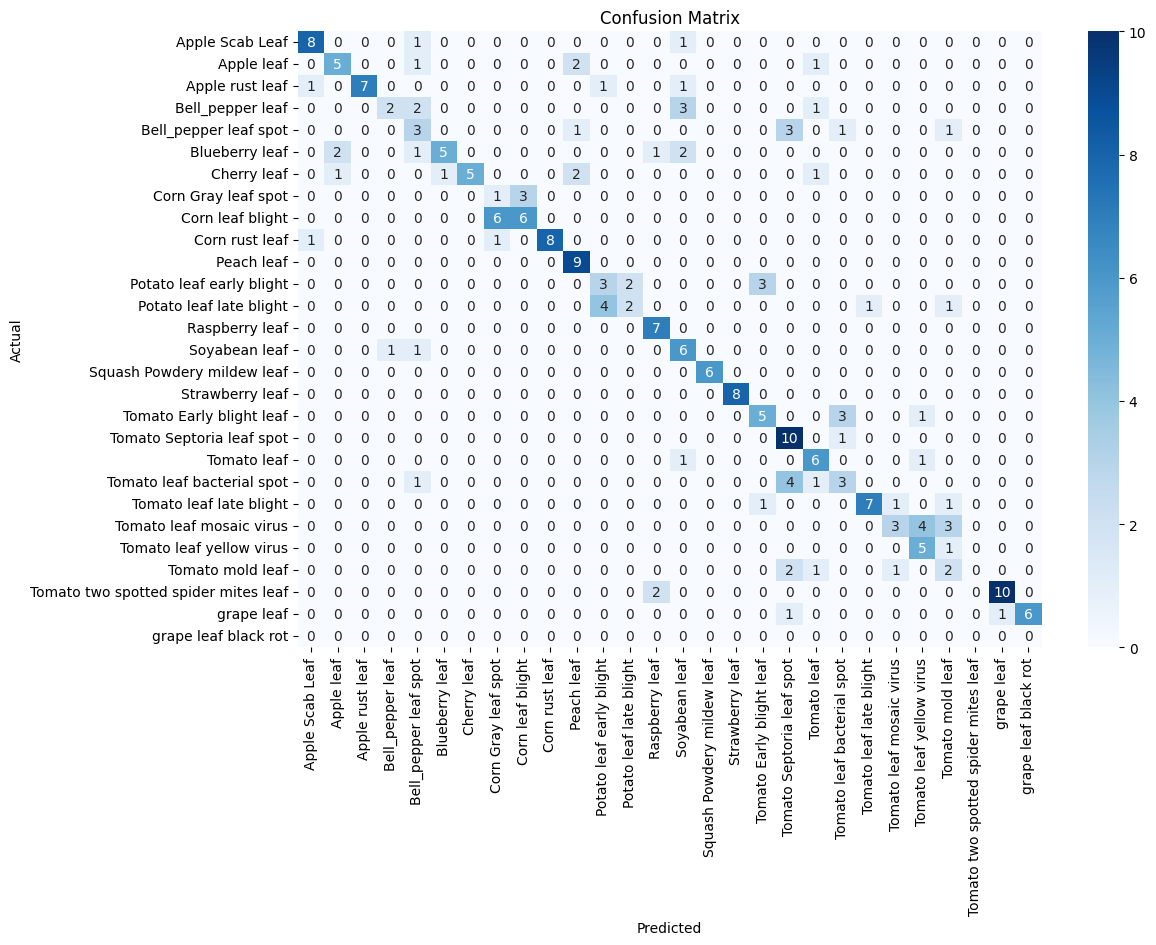

                                      precision    recall  f1-score   support

                     Apple Scab Leaf       0.80      0.80      0.80        10
                          Apple leaf       0.62      0.56      0.59         9
                     Apple rust leaf       1.00      0.70      0.82        10
                    Bell_pepper leaf       0.67      0.25      0.36         8
               Bell_pepper leaf spot       0.30      0.33      0.32         9
                      Blueberry leaf       0.83      0.45      0.59        11
                         Cherry leaf       1.00      0.50      0.67        10
                 Corn Gray leaf spot       0.12      0.25      0.17         4
                    Corn leaf blight       0.67      0.50      0.57        12
                      Corn rust leaf       1.00      0.80      0.89        10
                          Peach leaf       0.64      1.00      0.78         9
            Potato leaf early blight       0.38      0.38      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [8]:

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))


In [15]:
from random import random

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load class names
with open('class_names.txt', 'r') as f:
    class_names = [line.strip() for line in f.readlines()]
num_classes = len(class_names)

# Define transformation (same as training)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load trained model
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('best_plant_disease_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Pick a random image from the test folder
test_dir = './test'
all_images = []

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            all_images.append(os.path.join(root, file))

# Randomly select one image
image_path = rnd.choice(all_images)

# Prediction function
def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)
    return class_names[pred.item()]

# Predict and show result
prediction = predict_image(image_path, model, data_transforms, class_names)
print(f"Predicted class: {prediction}")
print(f"Image path: {image_path}")


Predicted class: Apple Scab Leaf
Image path: ./test/Corn rust leaf/0796.47southrust.jpg


In [ ]:

# app.py integration snippet for deployment
# This is a Flask API example to use the trained model

'''
from flask import Flask, request, jsonify
from PIL import Image
import io

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file provided'})
    file = request.files['file']
    image = Image.open(file.stream).convert('RGB')
    image_tensor = data_transforms['test'](image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, pred = torch.max(output, 1)

    return jsonify({'class': class_names[pred]})

if __name__ == '__main__':
    model.load_state_dict(torch.load('resnet50_best.pth'))
    model.eval()
    app.run(debug=True)
'''
